<a href="https://colab.research.google.com/github/satoruk-icepp/mlhep_phase1/blob/master/analysis/my_lhcb_calo_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = torch.device('cuda:0')

#### If you are using Google Colab you fill need following two lines of code

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Loading data

Data is stored in `.npz`-format which is a special filetype for persisting multiple NumPy arrays on disk. 

More info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format.

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [0]:
# open train dataset
data_real = np.load('/gdrive/My Drive/mlhep2019/data_train.npz', allow_pickle=True)
print(list(data_real.keys()))

EnergyDeposit    = data_real['EnergyDeposit']
ParticleMomentum = data_real['ParticleMomentum']
ParticlePoint    = data_real['ParticlePoint']
ParticlePDG      = data_real['ParticlePDG']
print(ParticlePoint.shape,ParticlePDG.shape)
ParticlePDG      = ParticlePDG.reshape([-1,1])
# print(ParticlePDG)
EnergyDeposit    = EnergyDeposit.reshape([-1,900])
dfene = pd.DataFrame(data = EnergyDeposit)
dfmom = pd.DataFrame(data = ParticleMomentum,columns=['px','py','pz'])
# print(dfmom)
dfpos = pd.DataFrame(data = ParticlePoint,columns=['x','y','z'])
# print(dfpos)
dfpar = pd.DataFrame(data = ParticlePDG,columns={'type'})
# df=dfmom+dfpos
# print(df_concat2)

# [data_size, 1]

df          = pd.concat([dfene,dfmom, dfpos,dfpar], axis=1)
df_gamma    = df[df.type==22]
df_eminus   = df[df.type==11]
# print(df['z'])

EnergyDeposit = EnergyDeposit.reshape([-1,1, 30, 30])
# plt.hist2d(df_gamma['px'],df_gamma['py'])

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']
(50250, 3) (50250,)


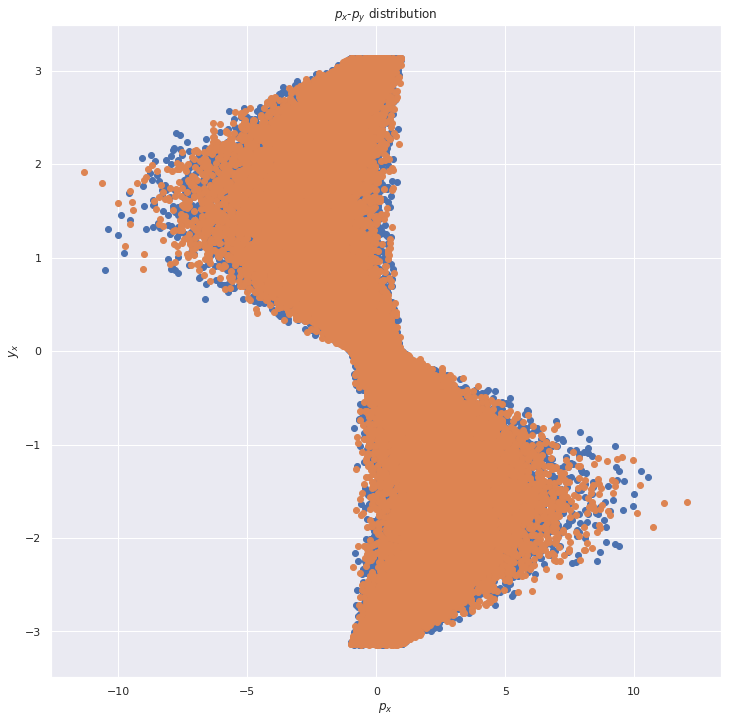

In [0]:
plt.figure(figsize=(12, 12))
plt.title('$p_x$-$p_y$ distribution')
# x=[]
# y=[]
# plt.scatter(ParticleMomentum[:, 1], ParticleMomentum[:, 0]);
# plt.scatter(df_gamma["y"],df_gamma["x"]);
# plt.scatter(df_eminus['y'],df_eminus["py"]**2+df_eminus["px"]**2);
plt.scatter(df_eminus['y'],np.arctan2(df_eminus["py"],df_eminus["px"]));
plt.scatter(df_gamma['y'],np.arctan2(df_gamma["py"],df_gamma["px"]));
# plt.hist2d(ParticleMomentum[:, 1], ParticlePoint[:, 1],bins=[100,100]);
plt.xlabel('$p_x$')
plt.ylabel('$y_x$')
plt.show()

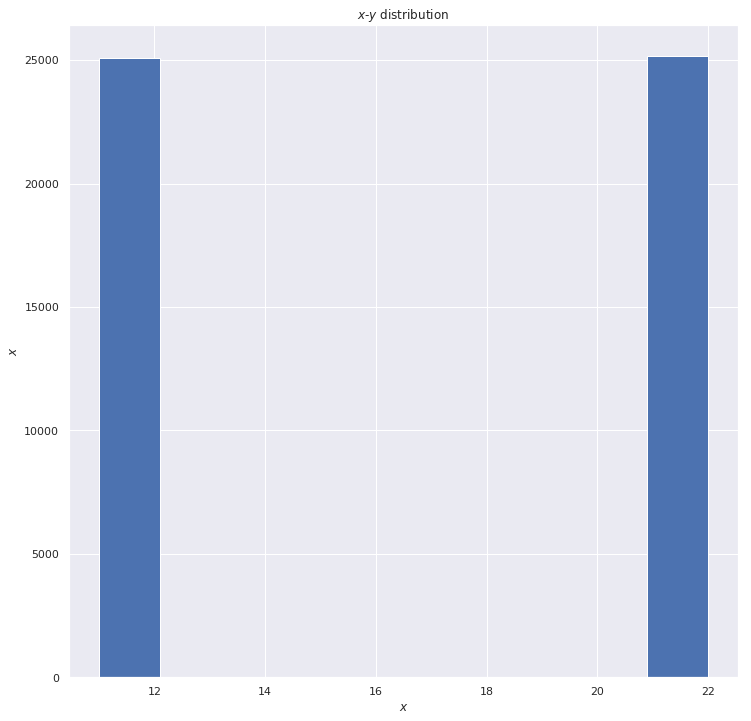

In [0]:
plt.figure(figsize=(12, 12))
plt.title('$x$-$y$ distribution')
# plt.scatter(ParticlePoint[:, 0], ParticlePoint[:, 1]);
plt.hist(df["type"]);
plt.xlabel('$x$')
plt.ylabel('$x$')
plt.show()

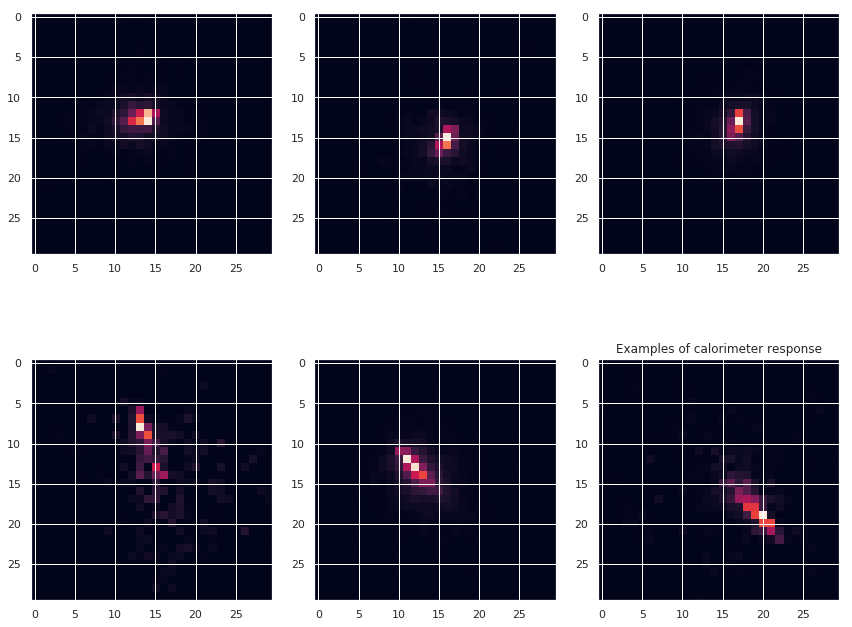

In [0]:
f, axs = plt.subplots(2, 3, figsize=(12, 10))

for i in range(6):
    axs[i // 3][i % 3].imshow(EnergyDeposit[i, 0])
plt.title('Examples of calorimeter response')
plt.tight_layout()
plt.show()

[22]
[22]
[22]
[22]
[22]
[22]
[22]
[22]
[22]


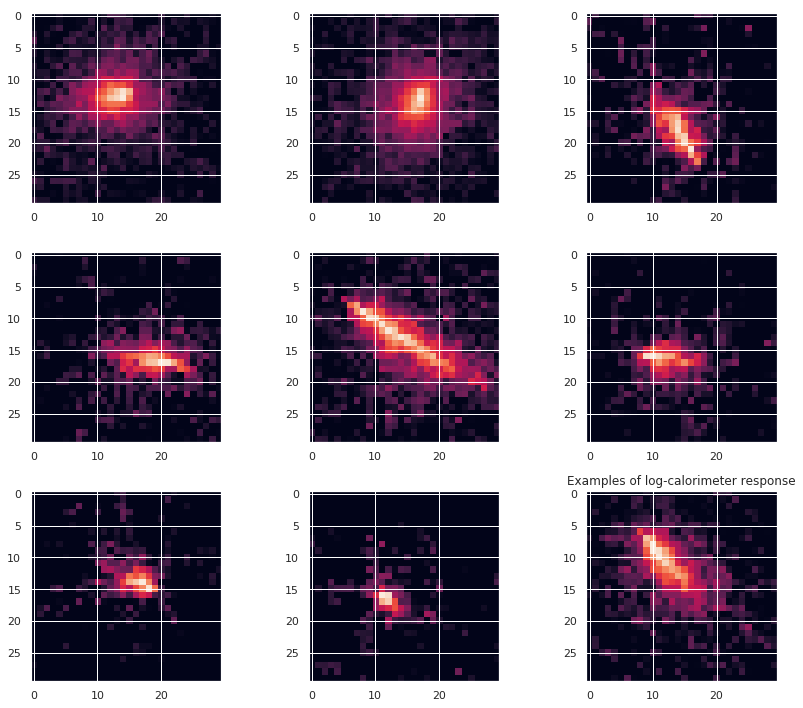

In [0]:
f, axs = plt.subplots(3, 3, figsize=(12, 10))
i=0
j=0
while j<9:
    if not ParticlePDG[i]==11:
        axs[j // 3][j % 3].imshow(np.log(1 + EnergyDeposit[i, 0]))
#         print(ParticlePDG[i])
        j+=1
    i+=1
plt.title('Examples of log-calorimeter response')
plt.tight_layout()
plt.show()

In [0]:
# not actully interested in p_z momentum
ParticleMomentum = ParticleMomentum[:, :2]
ParticlePoint = ParticlePoint[:, :2]

# Loading it to pytorch `DataLoader`

  1. Convert from `numpy`-array to Torch `tensors`

In [0]:
EnergyDeposit    = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint    = torch.tensor(ParticlePoint).float()
ParticlePDG      = torch.tensor(ParticlePDG).float()

  2. Convert three `tensors` to `TensorDataset`-format
  3. Wrapping it with `DataLoader`

In [0]:
from torch.utils.data.dataset import Subset
BATCH_SIZE = 1024
calo_dataset    = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint,ParticlePDG)
full_size = len(calo_dataset)
train_size = int(0.8*full_size)
subset1_indices = list(range(0,train_size))#train
subset2_indices = list(range(train_size,full_size))#validation

train_dataset = Subset(calo_dataset, subset1_indices)
val_dataset   = Subset(calo_dataset, subset2_indices)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)

# Defining our neural network regressor

![title](https://stackmorelayers.be/bg.png)

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.fc1 = nn.Linear(1600, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 2 + 2)
#         self.fc4 = nn.Linear(64, 1)
        self.fc4 = F.softmax(x,dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

# class Regressor(nn.Module):
#     def __init__(self):
#         super(Regressor, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 4, stride=2)
#         self.conv2 = nn.Conv2d(8, 16, 3)
#         self.conv3 = nn.Conv2d(16, 32, 3)
#         self.conv4 = nn.Conv2d(32, 64, 2)
#         self.conv5 = nn.Conv2d(64, 64, 2)
        
#         self.fc1 = nn.Linear(4096, 1200)
#         self.fc2 = nn.Linear(1200, 512)
#         self.fc3 = nn.Linear(512, 128)
#         self.fc4 = nn.Linear(128, 64)
#         self.fc5 = nn.Linear(64, 2 + 2)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x)) # 64, 8, 8
#         x = x.view(len(x), -1)

#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         return self.fc5(x)

In [0]:
regressor = Regressor().to(device)

# Defining optimizer


In [0]:
learning_rate = 1e-3
opt = optim.Adam(regressor.parameters(), lr=learning_rate)

## Relative MSE that is used in competition

In [0]:
# TODO: change
ParticleMomentum_mean, ParticlePoint_mean = ParticleMomentum.mean(dim=0), ParticlePoint.mean(dim=0)
ParticleMomentum_ParticlePoint_mean = torch.cat([ParticleMomentum_mean, ParticlePoint_mean]).to(device)
ParticlePDG_mean = ParticlePDG.mean(dim=0)
ParticlePDG_mean = ParticlePDG_mean.to(device)
# def metric_relative_mse(y_true, y_pred):
#     return ((y_true - y_pred).pow(2).mean(dim=0) / (y_true - ParticleMomentum_ParticlePoint_mean).pow(2).mean(dim=0)).sum()

def metric_relative_mse(y_true, y_pred):
    return ((y_true-y_pred).pow(2).mean(dim=0)/(y_true - ParticlePDG_mean).pow(2).mean(dim=0)).sum()

# Loss function

In this example we are using `L1Loss`. 

But maybe it's better to stick to another loss?.. `MSE` or `log-cosh`?..

In [0]:
# loss_fn = torch.nn.L1Loss().to(device)
# loss_fn = torch.nn.MSELoss().to(device)
loss_fn = torch.nn.SmoothL1Loss().to(device)

In [0]:
class RunningAverageMeter(object):
    """
    Computes and stores the average and current value
    
    """
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [0]:
def run_training(epochs=100):
    losses = []
    metrics = []
    train_epoch_vec=[]
    val_losses=[]
    val_metrics=[]
    val_epoch_vec=[]
    # init running average
    loss_meter   = RunningAverageMeter(momentum=0.99)
    metric_meter = RunningAverageMeter(momentum=0.99)
    val_loss_meter   = RunningAverageMeter(momentum=0.99)
    val_metric_meter = RunningAverageMeter(momentum=0.99)
    # iterating over epochs...
    for epoch in tqdm(range(epochs)):
        # ...and over batches
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b,ParticlePDG_b in train_dataloader:
            # moving them to device(for example, cuda-device)
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device), \
                                                                   ParticlePDG_b.to(device)
            
            # predicting an array of size [batch_size, 4]
            pred = regressor(EnergyDeposit_b)

            # calc loss function
#             print(pred.size(),torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1).size())
#             loss = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
#             print(pred.size(),ParticlePDG_b.size())
            loss = loss_fn(pred, torch.cat([ParticlePDG_b], dim=1))

            # manually zeroing gradients from previous step
            opt.zero_grad()
            
            # and calculating new gradients based on value of loss function
            loss.backward()
            
            # updating weights
            opt.step()
            
            # storing metrics for vizualization
            loss_meter.update(loss.item())
#             metric_meter.update(metric_relative_mse(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)).item())
            metric_meter.update(metric_relative_mse(pred, ParticlePDG_b).item())
            losses.append(loss_meter.avg)
            metrics.append(metric_meter.avg)
            train_epoch_vec.append(epoch)

        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b,ParticlePDG_b in val_dataloader:
            # moving them to device(for example, cuda-device)
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device), \
                                                                   ParticlePDG_b.to(device)
            
            # predicting an array of size [batch_size, 4]
            pred = regressor(EnergyDeposit_b)

            # calc loss function
#             print(pred.size(),torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1).size())
#             loss = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
#             print(pred.size(),ParticlePDG_b.size())
            loss = loss_fn(pred, torch.cat([ParticlePDG_b], dim=1))

#             # manually zeroing gradients from previous step
#             opt.zero_grad()
            
#             # and calculating new gradients based on value of loss function
#             loss.backward()
            
#             # updating weights
#             opt.step()
            
#             # storing metrics for vizualization
            val_loss_meter.update(loss.item())
#             val_metric_meter.update(metric_relative_mse(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)).item())
            val_metric_meter.update(metric_relative_mse(pred, ParticlePDG_b).item())
            val_losses.append(val_loss_meter.avg)
            val_metrics.append(val_metric_meter.avg)
            val_epoch_vec.append(epoch)
        # plot loss and our metric
        clear_output()

    plt.figure(figsize=(12, 12))
    plt.plot(losses, label='Loss')
    plt.legend()py
    plt.show()
        
    plt.figure(figsize=(12, 12))
    plt.semilogy(train_epoch_vec,metrics, label='Metric')
    plt.semilogy(val_epoch_vec,val_metrics, label='Metric')
#     plt.("log", nonposy='clip')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


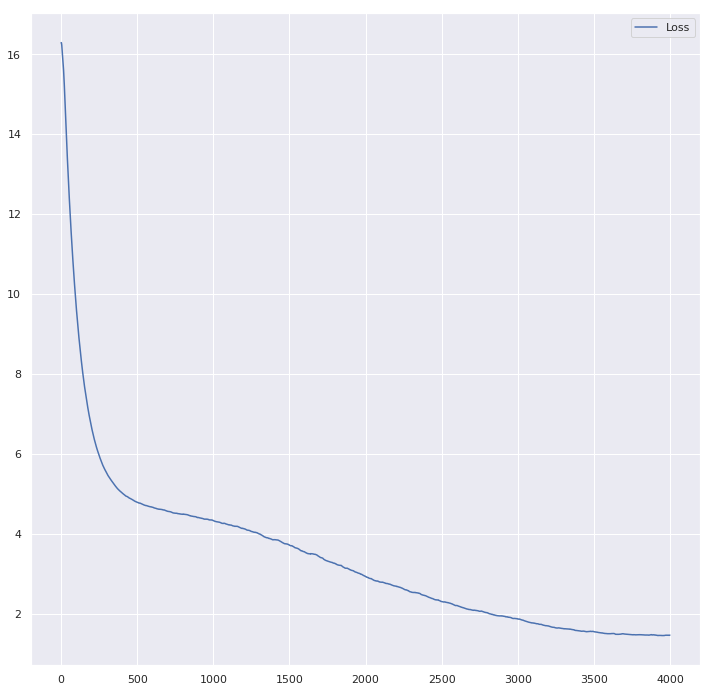

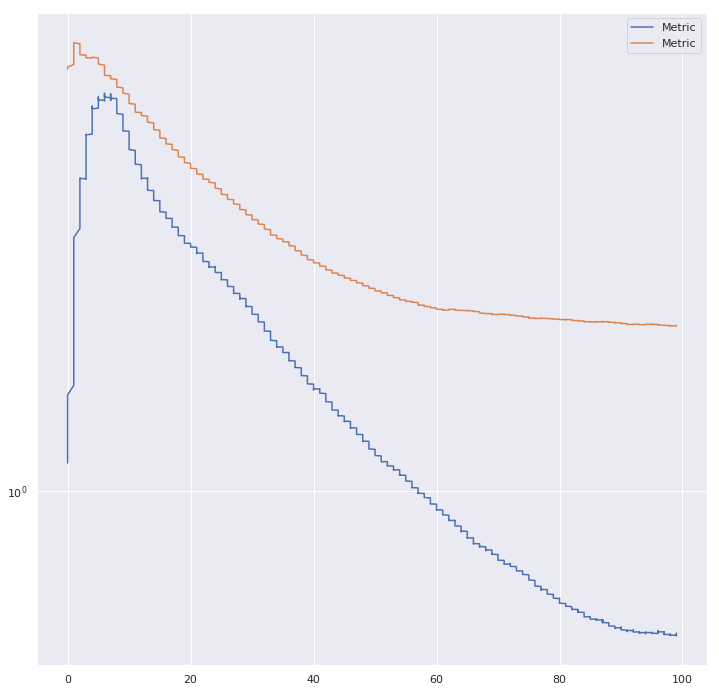

In [0]:
# 10 epoch enought?
run_training(100)

## Make predictions for validation set

In `data_val.npz` and `data_test.npz` you only have one key: `EnergyDeposit`.

In [0]:
# load validation data
data_val = np.load('/gdrive/My Drive/mlhep2019/data_val.npz', allow_pickle=True)
EnergyDeposit_val = data_val['EnergyDeposit']
EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 1, 30, 30)

In [0]:
# predicting [data_num, 4] array with px, py, x, y
prediction_val = regressor.cpu()(torch.tensor(EnergyDeposit_val).float())

In [0]:
# splitting ParticleMomentum and ParticlePoint in two arrays
ParticleMomentum_val, ParticlePoint_val = prediction_val.detach().numpy()[:, :2], prediction_val.detach().numpy()[:, 2:]

In [0]:
# saving predictions in .npz format
np.savez_compressed('data_val_prediction.npz', 
                    ParticlePoint=ParticlePoint_val, 
                    ParticleMomentum=ParticleMomentum_val)

## Make predictions for test set

In [0]:
# loading test dataset
data_test = np.load('/gdrive/My Drive/mlhep2019/data_test.npz', allow_pickle=True)

EnergyDeposit_test = data_test['EnergyDeposit']
EnergyDeposit_test = EnergyDeposit_test.reshape(-1, 1, 30, 30)

In [0]:
# predicting [data_num, 4] array with px, py, x, y
prediction_test = regressor.cpu()(torch.tensor(EnergyDeposit_test).float())

In [0]:
# splitting ParticleMomentum and ParticlePoint in two arrays
ParticleMomentum_test, ParticlePoint_test = prediction_test.detach().numpy()[:, :2], prediction_test.detach().numpy()[:, 2:]

In [0]:
# saving predictions in .npz format
np.savez_compressed('data_test_prediction.npz', 
                    ParticlePoint=ParticlePoint_test, 
                    ParticleMomentum=ParticleMomentum_test)

Test Score# 新しいセクション

In [0]:
# import numpy as np

# ParticleMomentum_MEAN = np.array([0., 0.])
# ParticlePoint_MEAN = np.array([0., 0.])

# def scoring_function(solution_file, predict_file):
#     score = 0.
    
#     solution = np.load(solution_file, allow_pickle=True)
#     predict = np.load(predict_file, allow_pickle=True)
#     ParticleMomentum_sol = solution['ParticleMomentum'][:, :2]
#     ParticlePoint_sol = solution['ParticlePoint'][:, :2]
    
#     ParticleMomentum_pred = predict['ParticleMomentum'][:, :2]
#     ParticlePoint_pred = predict['ParticlePoint'][:, :2]
    
#     score += np.sum(np.square(ParticleMomentum_sol - ParticleMomentum_pred).mean(axis=0) / np.square(ParticleMomentum_sol - ParticleMomentum_MEAN).mean(axis=0))
#     score += np.sum(np.square(ParticlePoint_sol - ParticlePoint_pred).mean(axis=0) / np.square(ParticlePoint_sol - ParticlePoint_MEAN).mean(axis=0))
#     return np.sqrt(score)



## `zip-zip` files together

In [0]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

In [0]:
from IPython.display import FileLink
FileLink('./solution.zip')

In [0]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

## Awesome, you are breathtaking!

![](https://i.kym-cdn.com/entries/icons/original/000/030/029/cover2.jpg)

Now you can send it to codalab :)

If you forgot where it is: http://codalab.coresearch.club/competitions/70

## Future steps:

1. Tune arcitecture 
  * stack moar layers :)
  * different types on nonlinearities, hyperparameters of `Conv2d`-layer, initializations, etc...
  * dropout & other regularizations
  
  
2. Play with optimization procedure
  * train for more epochs
  * maybe looking at train metricis is not the best way to prevent overfitting :)
  * learning rate scheduler
  * early stopping
  * different types of loss functions: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
  * SWA: https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/
  
  
3. data augmentation
  * rotate & shift images(do not forget to transform $p_x, p_y$, $x, y$ as well!)
  * adding nose to images/target variables
  
  
4. other trick
  * train to predict $p_z$ and particle type: multi-task or/and transfer learning( http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_15_multi_task_learning.pdf )
  * normalization of input/output data: Box-Cox transformation